In [2]:
from scapy.all import rdpcap, TCP, UDP, IP, Ether
import pandas as pd
import numpy as np
from datetime import datetime
import pyshark
import hashlib
import matplotlib.pyplot as plt



In [3]:
pcap = "swell/test_1/capture.pcap"
packets = rdpcap(pcap)
total_packets = len(packets)
print(f"Total number of packets: {total_packets}")

Total number of packets: 137077


In [ ]:
#packets[560][TCP].show()
#packets[560][TCP].summary()
packet = packets[3444]
packet.show()
#packet.summary()

In [7]:
def tcp_flags(flags):
    """FIN-ACK  AF  0x011 | FIN	F	0x01 | SYN-ACK	AS	0x012 | SYN	S	0x02 | RST	R	0x04 | PSH	P	0x08 | ACK	A	0x10 | URG	U	0x20 """
    if (flags & 0x02) and (flags & 0x10): return 'SYN-ACK'      #start of a connection
    if (flags & 0x01) and (flags & 0x10): return 'FIN-ACK'      #end of a connection
    if (flags & 0x08) and (flags & 0x10): return 'PSH-ACK'
    if flags & 0x01: return 'FIN'
    if flags & 0x02: return 'SYN'
    if flags & 0x04: return 'RST'
    if flags & 0x08: return 'PSH'
    if flags & 0x10: return 'ACK'
    if flags & 0x20: return 'URG'

    return 'UNKNOWN'

In [8]:
def hash_payload(payload):
    return hashlib.md5(bytes(payload)).hexdigest() if payload else None

In [9]:
def retransmission_check(packet):
    if IP not in packet or TCP not in packet:
        return
    
    ip = packet[IP]
    tcp = packet[TCP]
    payload = tcp.payload
    payload_len = len(payload)

    if payload_len == 0:        # len is zero means no payload like pure ack, syn, etc. so no retransmission
        return

    key = (ip.src, ip.dst, tcp.sport, tcp.dport, 'TCP') #define a key to be able to check based on it if multiple concurrent connections
    if key not in connections:
        connections[key] = []

    seq = tcp.seq
    payload_hash = hash_payload(payload)

    covered = connections[key]
    match = next(
        (item for item in covered if item[0] == seq and item[1] == payload_len),
        None
    )

    if match:
        if match[2] == payload_hash:
            print(f"retransmission in {key} at Seq={seq} (Len={payload_len})")
        else:
            print(f"same Seq={seq}, but payload differs - (possible overlap or issue in {key})")
    else:
        covered.append((seq, payload_len, payload_hash))

In [10]:
ports = [5100, 5101, 5102, 5103, 5104,
         5074, 5075, 5076, 5077, 5078]
ips = ['128.135.24.118', '128.135.24.120',
       '128.135.24.117', '128.135.24.119']
stream = []

#in retransmission:
connections = {}
seq_tracker = set()
covered = []

filtered_pakckets = [p for p in packets if p.haslayer('TCP') and 
                     (p[TCP].sport in ports or p[TCP].dport in ports) and 
                     (p[IP].src in ips or p[IP].dst in ips)]
#print(len(filtered_pakckets))

for packet in filtered_pakckets:
    if packet.haslayer(TCP) and packet.haslayer(IP):
        entry = {
            'Timestamp': datetime.fromtimestamp(float(packet.time)),
            'Src_IP': packet[IP].src,
            'Dst_IP': packet[IP].dst,
            'Src_Port': packet[TCP].sport,
            'Dst_Port': packet[TCP].dport,
            'Packet_Seq': packet[TCP].seq,
            'Packet_Ack': packet[TCP].ack,
            'Packet_Size': len(packet[TCP].payload),
            'Packet_Flags': tcp_flags(packet[TCP].flags),
            'Retransmission': True if packet[TCP].seq in seq_tracker else False,
            'Payload_Hash': hash_payload(packet[TCP].payload),
        }
        
        stream.append(entry)

In [11]:
df = pd.DataFrame(stream)

df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="ms")
#print(f"Total retransmissiones: {df['Retransmission'].sum()}")  
#print(df['Timestamp'].is_monotonic_increasing)
#print(df.head(10))
#print(df.tail())
print(df.info())

print(df.describe())
df['Packet_Size'].value_counts().sort_index(ascending=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11379 entries, 0 to 11378
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       11379 non-null  datetime64[ns]
 1   Src_IP          11379 non-null  object        
 2   Dst_IP          11379 non-null  object        
 3   Src_Port        11379 non-null  int64         
 4   Dst_Port        11379 non-null  int64         
 5   Packet_Seq      11379 non-null  int64         
 6   Packet_Ack      11379 non-null  int64         
 7   Packet_Size     11379 non-null  int64         
 8   Packet_Flags    11379 non-null  object        
 9   Retransmission  11379 non-null  bool          
 10  Payload_Hash    8172 non-null   object        
dtypes: bool(1), datetime64[ns](1), int64(5), object(4)
memory usage: 900.2+ KB
None
                           Timestamp      Src_Port      Dst_Port  \
count                          11379  11379.000000  11379.0000

Packet_Size
0        3207
6           9
10          1
11          1
27          1
28          1
36       1502
44          1
53          1
54          1
84          1
87         13
324         1
655        27
892        69
1223      158
1460     2158
1547        7
1784      234
2115       40
2352       56
2683      622
2920      627
3244        3
3575      109
3812       76
4143       98
4380      184
4704        3
5035      242
5272       59
5840      162
6495       37
6732      204
7300      277
7387        4
7955       27
8192       85
8760       17
8847        1
9084        2
9415       47
9652       13
10220      19
10307       1
10544       4
10875      60
11112      19
11680      70
11767       5
12004      15
12335       1
12572       5
13140     169
13227       1
13464     167
14032       4
14600       2
14924     449
Name: count, dtype: int64

In [12]:
total_packets = df['Packet_Size'].count()
total_size = df['Packet_Size'].sum()
avg_packet_size = df['Packet_Size'].quantile(0.5)
#print(df['Packet_Flags'].unique())
duration = (df[df['Packet_Flags'] == 'FIN-ACK']['Timestamp'].max()) - (df[df['Packet_Flags'] == 'SYN-ACK']['Timestamp'].min())  #end - start

print(f"duration of the streaming: {duration}")
print(f"Total number of packets: {total_packets}")
print(f"Average packet size: {avg_packet_size} Bytes")
print(f"Total size of packets: {total_size} Bytes ~ {(total_size / (1024 * 1024)):.2f} MB ~ {(total_size / (1024 * 1024 * 1024)):.2f} GB")


duration of the streaming: 0 days 00:23:10.742330
Total number of packets: 11379
Average packet size: 1460.0 Bytes
Total size of packets: 30844937 Bytes ~ 29.42 MB ~ 0.03 GB


TODO: get the duration of each frame and compare it to the total!!!

<Axes: title={'center': 'Packet Size'}, xlabel='Timestamp'>

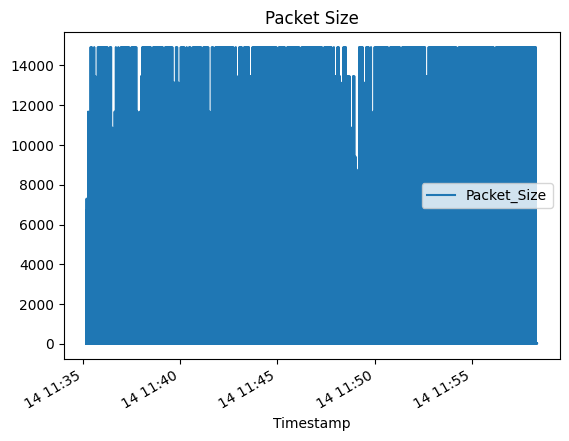

In [32]:
df.plot(x="Timestamp", y="Packet_Size", title="Packet Size", kind="line")
#df.set_index("Timestamp").resample("1s")['Packet_Size'].plot(title="Packets per second", kind="line")

<Axes: title={'center': 'packet cnt per sec'}, xlabel='Timestamp'>

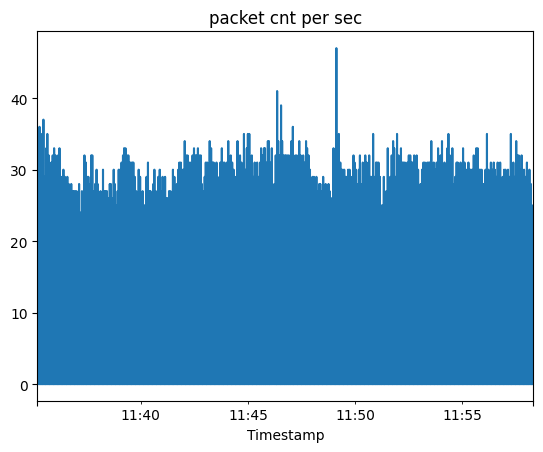

In [27]:
df.set_index("Timestamp").resample("1s")["Packet_Size"].count().plot(title="packet cnt per sec")    # packet count over time or activity level

<Axes: title={'center': 'bytes per sec'}, xlabel='Timestamp'>

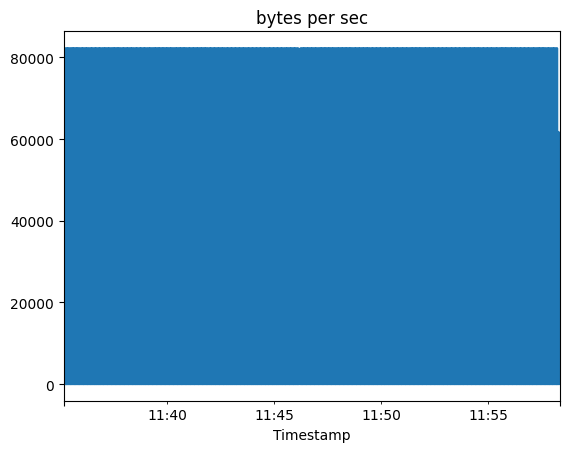

In [26]:
df.set_index("Timestamp").resample("1s")["Packet_Size"].sum().plot(title="bytes per sec")        # throughput approximation

In [ ]:
df.to_csv("stream_packets.csv", index=False)